# 聚类算法

In [1]:
#导入必要的工具包
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#读取训练数据
train_test_events_ID = pd.read_csv('train_clustering.csv')
events = pd.read_csv('events.csv',nrows = 100000) #由于数据量太大，读取前100000条数据

In [3]:
train_test_events_ID.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13418 entries, 0 to 13417
Data columns (total 1 columns):
ID    13418 non-null int64
dtypes: int64(1)
memory usage: 104.9 KB


In [4]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 110 entries, event_id to c_other
dtypes: float64(2), int64(103), object(5)
memory usage: 83.9+ MB


In [5]:
#通过id从event.csv中找到同时在test 和 train中出现的活动
events_selected = pd.DataFrame()
for i in train_test_events_ID['ID']:
    if events.loc[events['event_id'] == i].empty == False:
        data = events.loc[events['event_id'] == i]
        events_selected = events_selected.append(data, ignore_index = True)   

In [6]:
events_selected.dtypes

event_id        int64
user_id         int64
start_time     object
city           object
state          object
zip            object
country        object
lat           float64
lng           float64
c_1             int64
c_2             int64
c_3             int64
c_4             int64
c_5             int64
c_6             int64
c_7             int64
c_8             int64
c_9             int64
c_10            int64
c_11            int64
c_12            int64
c_13            int64
c_14            int64
c_15            int64
c_16            int64
c_17            int64
c_18            int64
c_19            int64
c_20            int64
c_21            int64
               ...   
c_72            int64
c_73            int64
c_74            int64
c_75            int64
c_76            int64
c_77            int64
c_78            int64
c_79            int64
c_80            int64
c_81            int64
c_82            int64
c_83            int64
c_84            int64
c_85            int64
c_86      

In [7]:
#Drop 前面无用信息
events_selected = events_selected.drop(columns = ['event_id', 'user_id', 'start_time', 'city', 'state', 'zip', 'country', 'lat', 'lng'])

In [8]:
events_selected.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,...,c_92,c_93,c_94,c_95,c_96,c_97,c_98,c_99,c_100,c_other
0,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,96
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,7
3,0,0,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
4,2,0,0,0,2,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,4


In [9]:
events_selected.describe()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,...,c_92,c_93,c_94,c_95,c_96,c_97,c_98,c_99,c_100,c_other
count,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,...,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000
mean,1.672000,1.043556,1.130667,0.688000,0.711111,1.668444,0.576889,0.692444,0.401778,0.300444,...,0.076444,0.073778,0.226667,0.041778,0.059556,0.068444,0.049778,0.041778,0.058667,39.018667
std,3.053201,2.200951,2.145879,1.491222,1.639458,4.976933,1.307179,1.464766,1.141422,0.887061,...,0.303341,0.290533,0.574673,0.240544,0.373749,0.357594,0.331089,0.346611,0.301432,54.127737
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000
75%,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000
max,28.000000,33.000000,21.000000,14.000000,21.000000,58.000000,14.000000,23.000000,9.000000,9.000000,...,4.000000,2.000000,4.000000,4.000000,7.000000,5.000000,5.000000,6.000000,4.000000,553.000000


In [19]:
#数据除归一化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=True, with_mean=True)
scaler.fit(events_selected)
events_selected_s = scaler.transform(events_selected)

In [25]:
events_selected_columns = events_selected.columns.values.tolist() #存储labels
events_selected_s=pd.DataFrame(events_selected_s, columns = events_selected_columns)

In [28]:
#对数据进行PCA降维
pca = PCA(n_components = 0.75)
pca.fit(events_selected_s)
events_selected_s_pca = pca.transform(events_selected_s)
#降维后的特征维度数
print(events_selected_s_pca.shape)

(1125, 38)


In [29]:
#一个参数点（聚类数据为K）的模型
def K_cluster_analysis(K, X_train):
    start = time.time()
    print("K-means begin with clusters:{}".format(K));
    
    #K-means, 在训练集上训练
    mb_kmeans = MiniBatchKMeans(n_clusters = K)
    mb_kmeans.fit(X_train)
    # K值的评估标准
    #常见的方法有轮廓系数Silhouette Coefficient和Calinski-Harabasz Index
    #这两个分数值越大则聚类效果越好
    CH_score = metrics.silhouette_score(X_train,mb_kmeans.predict(X_train))
    end = time.time()
    print("CH_score: {}, time elaps:{}".format(CH_score, int(end-start)))
    return CH_score

In [30]:
# 设置超参数（聚类数目K）搜索范围
Ks = [10,20,30,40,50,60,70,80,90,100]
CH_scores = []
for K in Ks:
    ch = K_cluster_analysis(K, events_selected_s_pca)
    CH_scores.append(ch)

K-means begin with clusters:10
CH_score: 0.23030762574475708, time elaps:0
K-means begin with clusters:20
CH_score: 0.21785545557223027, time elaps:0
K-means begin with clusters:30
CH_score: 0.06087123538096545, time elaps:0
K-means begin with clusters:40
CH_score: 0.13160666706516935, time elaps:0
K-means begin with clusters:50
CH_score: 0.1315954430250508, time elaps:0
K-means begin with clusters:60
CH_score: 0.11421593924367522, time elaps:0
K-means begin with clusters:70
CH_score: 0.09199286207858015, time elaps:0
K-means begin with clusters:80
CH_score: 0.11774807372948494, time elaps:0
K-means begin with clusters:90
CH_score: 0.1491712078011685, time elaps:0
K-means begin with clusters:100
CH_score: 0.15383689976554943, time elaps:0


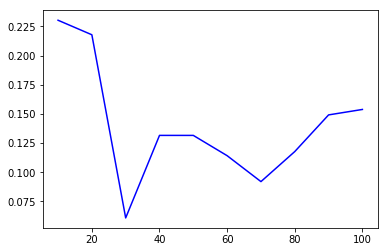

In [31]:
# 绘制不同PCA维数下模型的性能，找到最佳模型／参数（分数最高）
plt.plot(Ks, np.array(CH_scores), 'b-')

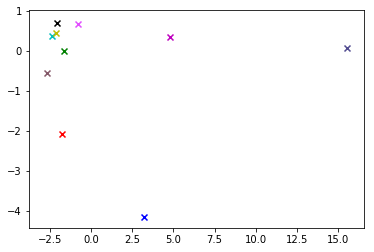

In [32]:
colors = ['b','g','r','k','c','m','y','#e24fff','#524C90','#845868']

n_clusters = 10
mb_kmeans = MiniBatchKMeans(n_clusters = n_clusters)
mb_kmeans.fit(events_selected_s_pca)

y_train_pred = mb_kmeans.labels_
cents = mb_kmeans.cluster_centers_#质心

for i in range(n_clusters):
    index = np.nonzero(y_train_pred==i)[0]
    x1 = events_selected_s_pca[index,0]
    x2 = events_selected_s_pca[index,1]
    plt.scatter(cents[i,0],cents[i,1],marker='x',color=colors[i],linewidths=12)



分类效果并不是很好，由于数据过多，为只打印了核心点，可以看出核心点非常集中，分类不是很好。